## CSCI 5931: Deep Learning¶
### Final Project
### Team: Supriya Ramachandra, Kimberly Knudtson

### Importing libraries

In [101]:
import os
import  cv2
from PIL import Image
import math
import numpy as np 
import pandas as pd
from tqdm import tqdm
import pickle
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
from random import shuffle , seed
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from skmultilearn.model_selection import iterative_train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.keras.applications.densenet import DenseNet169
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input ,concatenate, Dense,Flatten , Activation,Conv2D ,Dropout ,MaxPooling2D ,GlobalAveragePooling2D,BatchNormalization

In [ ]:
!pip install scikit-multilearn

     |████████████████████████████████| 92kB 10.5MB/s 


In [102]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

In [ ]:
device_name

'/device:GPU:0'

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 15321117831768908038, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 14674281152
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 12586206180867330733
 physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"]

### Load and read CSV files into pandas dataframe

In [103]:
chest_df = pd.read_csv('/content/drive/My Drive/sample_labels.csv')
chest_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [104]:
ls = chest_df['Finding Labels'].unique()
#number of unique labels
print(len(ls))

244


In [105]:
labels = list(chest_df['Finding Labels'])
labels[:100]

['Emphysema|Infiltration|Pleural_Thickening|Pneumothorax',
 'Cardiomegaly|Emphysema',
 'No Finding',
 'Atelectasis',
 'Cardiomegaly|Edema|Effusion',
 'Consolidation|Mass',
 'No Finding',
 'No Finding',
 'Effusion',
 'No Finding',
 'Consolidation|Effusion|Infiltration|Nodule',
 'Mass',
 'No Finding',
 'No Finding',
 'Effusion',
 'Effusion',
 'Effusion',
 'No Finding',
 'Mass|Pneumothorax',
 'Cardiomegaly|Consolidation',
 'Consolidation',
 'Cardiomegaly|Consolidation',
 'Cardiomegaly|Consolidation',
 'Pneumothorax',
 'No Finding',
 'Effusion',
 'Consolidation|Pleural_Thickening',
 'Infiltration|Nodule',
 'No Finding',
 'Atelectasis',
 'Atelectasis',
 'Fibrosis',
 'Infiltration',
 'Infiltration',
 'No Finding',
 'No Finding',
 'No Finding',
 'No Finding',
 'Fibrosis',
 'No Finding',
 'Consolidation',
 'Emphysema',
 'No Finding',
 'No Finding',
 'Infiltration',
 'Consolidation|Mass',
 'No Finding',
 'Atelectasis|Infiltration|Mass|Pleural_Thickening',
 'Infiltration',
 'No Finding',
 'No Fi

In [106]:
labels_initial = chest_df["Finding Labels"]

### Display Few Images from NIH chest x-ray dataset

In [ ]:
def get_filenames(data_dir):
    # loads the pictures into a list
    # data_dir: the CroppedYale folder
    # view_list: the views you wish to grab
    dir_list = os.listdir(data_dir)
    file_list = []
    for dir in dir_list:
        #view_list = random.sample(range(1, 11), 5)
        if not dir.startswith('.'):
                filename = "%s/%s" % (data_dir, dir)
                file_list.append(filename)
    return(file_list),dir_list

file_list,dir_list = get_filenames('/content/drive/My Drive/images/')
#print(dir_list)

In [ ]:
def image_grid(D,H,W,cols=10,scale=1):
    n = np.shape(D)[0]
    rows = int(math.ceil((n+0.0)/cols))
    fig = plt.figure(1,figsize=[scale*20.0/H*W,scale*20.0/cols*rows],dpi=300)
    for i in range(n):
        plt.subplot(rows,cols,i+1)
        fig=plt.imshow(np.reshape(D[i,:],[H,W]), cmap = plt.get_cmap("gray"))
        plt.axis('off')
        plt.title(dir_list[i].split('.',1)[0])
        #plt.title(labels[i])

In [ ]:
im = Image.open(file_list[0]).convert("L")
H,W = np.shape(im)
print('shape=%d x %d => %d pixels'%(H,W, H*W))
#im_number = len(file_list)
im_number=20
arr = np.zeros([im_number,H*W])
for i in range(im_number):
    im = Image.open(file_list[i]).convert("L")
    arr[i,:] = np.reshape(np.asarray(im),[1,H*W])

image_grid(arr,H,W)

Output hidden; open in https://colab.research.google.com to view.

### Exploratory Data Analysis

In [ ]:
chest_df.describe()

,Follow-up #,Patient ID,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
count,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000,5606.000000
mean,8.616661,14330.617017,2644.795755,2491.087406,0.155467,0.155467
std,15.565815,8411.477789,347.188754,399.119063,0.016201,0.016201
min,0.000000,13.000000,1362.000000,966.000000,0.115000,0.115000
25%,0.000000,7289.000000,2500.000000,2048.000000,0.143000,0.143000
50%,3.000000,13993.000000,2542.000000,2544.000000,0.143000,0.143000
75%,10.000000,20655.500000,2992.000000,2991.000000,0.168000,0.168000
max,177.000000,30797.000000,3266.000000,3056.000000,0.198800,0.198800


In [ ]:
chest_df.isnull().sum()

Image Index                    0
Finding Labels                 0
Follow-up #                    0
Patient ID                     0
Patient Age                    0
Patient Gender                 0
View Position                  0
OriginalImageWidth             0
OriginalImageHeight            0
OriginalImagePixelSpacing_x    0
OriginalImagePixelSpacing_y    0
dtype: int64

In [ ]:
unique_pt = chest_df['Patient ID'].nunique()
print(f'Total number of unique patient: {unique_pt}')

Total number of unique patient: 4230


In [ ]:
data = chest_df[['Image Index','Finding Labels','Follow-up #','Patient ID','Patient Age','Patient Gender']]
#new columns for each disease
pathology_list = ['Cardiomegaly','Emphysema','Effusion','Hernia','Nodule','Pneumothorax','Atelectasis','Pleural_Thickening','Mass','Edema','Consolidation','Infiltration','Fibrosis','Pneumonia']
for pathology in pathology_list :
    data[pathology] = data['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

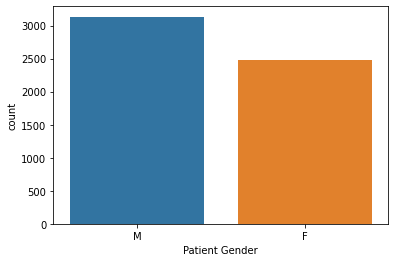

In [ ]:
sns.countplot(chest_df["Patient Gender"])
plt.show()

In [ ]:
patient_age_max = chest_df['Patient Age'].max()
patient_age_min = chest_df['Patient Age'].min()
print(f'maximum patient age is {patient_age_max}')
print(f'minimum patient age is {patient_age_min}')

maximum patient age is 411Y
minimum patient age is 001D


In [ ]:
chest_df['Patient Age'] = chest_df['Patient Age'].str.replace('[Y,D,M]', '')

In [ ]:
chest_df['Patient Age'] = chest_df['Patient Age'].apply(pd.to_numeric)

In [ ]:
patient_age = chest_df['Patient Age'].value_counts()
print(patient_age)

58     167
54     158
55     152
57     148
51     147
      ... 
88       1
1        1
86       1
94       1
411      1
Name: Patient Age, Length: 91, dtype: int64


In [ ]:
age_100plus = chest_df[chest_df['Patient Age'] >100]['Patient Age']
age_10minus = chest_df[chest_df['Patient Age'] <10]['Patient Age']
print(f'Total Patients age above 100 years: {len(age_100plus)} ')
print(f'Total Patients age below 10 years: {len(age_10minus)} ')

Total Patients age above 100 years: 1 
Total Patients age below 10 years: 85 


In [ ]:
above_100_years =chest_df.loc[age_100plus.index]
above_100_years

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
4242,00020900_002.png,No Finding,2,20900,411,M,AP,3056,2544,0.139,0.139


In [ ]:
below_10_years =chest_df.loc[age_10minus.index]
below_10_years.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
325,00001717_000.png,No Finding,0,1717,9,F,PA,2048,2500,0.171,0.171
665,00003438_001.png,No Finding,1,3438,8,F,PA,2048,2500,0.168,0.168
670,00003465_004.png,No Finding,4,3465,6,F,AP,2048,2500,0.168,0.168
801,00004169_000.png,Pneumothorax,0,4169,9,F,AP,2500,2048,0.171,0.171
994,00005204_001.png,No Finding,1,5204,6,F,AP,2500,2048,0.171,0.171


In [ ]:
Bbox_list_df = pd.read_csv('/content/drive/My Drive/BBox_List_2017.csv')

In [ ]:
merged_df = chest_df.merge(Bbox_list_df, how = 'inner', on = ['Image Index'])

In [ ]:
merged_df.columns

Index(['Image Index', 'Finding Labels', 'Follow-up #', 'Patient ID',
       'Patient Age', 'Patient Gender', 'View Position', 'OriginalImageWidth',
       'OriginalImageHeight', 'OriginalImagePixelSpacing_x',
       'OriginalImagePixelSpacing_y', 'Finding Label', 'Bbox [x', 'y', 'w',
       'h]', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'],
      dtype='object')

In [ ]:
merged_df.drop(['Unnamed: 6','Unnamed: 7','Unnamed: 8'], axis = 1, inplace= True)
merged_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,Finding Label,Bbox [x,y,w,h]
0,00001153_004.png,Atelectasis,4,1153,64,M,AP,2500,2048,0.168,0.168,Atelectasis,307.029340,253.914080,97.848889,439.182222
1,00001373_009.png,Cardiomegaly,9,1373,58,M,AP,2500,2048,0.168,0.168,Cardiomegaly,412.850794,468.114286,548.300529,501.705820
2,00002395_007.png,Effusion,7,2395,62,F,AP,2500,2048,0.168,0.168,Effusion,231.537778,448.606823,75.093333,158.151111
3,00003789_000.png,Nodule|Pneumonia,0,3789,41,M,AP,2500,2048,0.171,0.171,Pneumonia,272.497778,569.211267,100.124444,93.297778
4,00004342_020.png,Cardiomegaly,20,4342,43,M,PA,2936,2991,0.143,0.143,Cardiomegaly,316.410582,386.844444,474.615873,431.271958


In [ ]:
chest_df["Finding Labels"].value_counts()

No Finding                                                     3044
Infiltration                                                    503
Effusion                                                        203
Atelectasis                                                     192
Nodule                                                          144
                                                               ... 
Atelectasis|Consolidation|Effusion|Mass|Nodule|Pneumothorax       1
Cardiomegaly|Consolidation|Pneumonia                              1
Atelectasis|Emphysema|Infiltration|Nodule|Pneumothorax            1
Atelectasis|Consolidation|Mass|Pneumothorax                       1
Consolidation|Edema|Effusion|Pneumonia                            1
Name: Finding Labels, Length: 244, dtype: int64

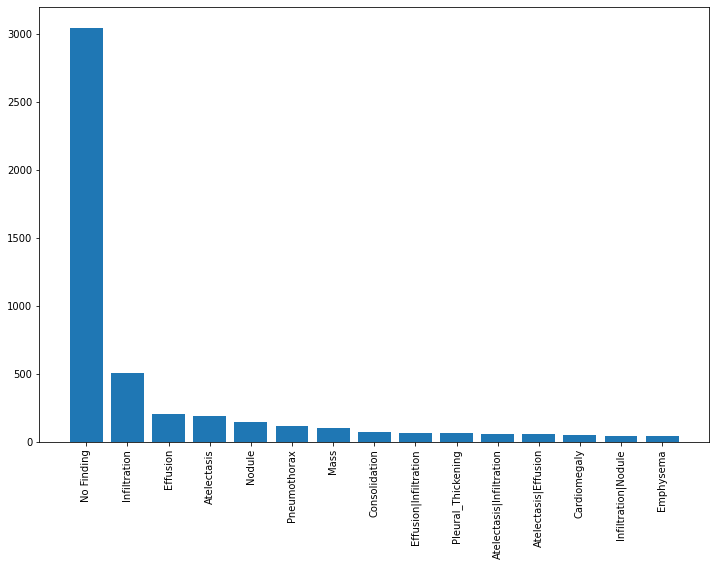

In [ ]:
label_counts = chest_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

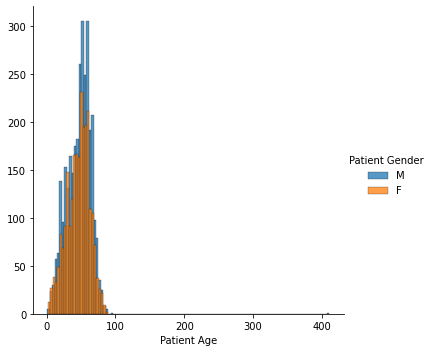

In [ ]:
sns.FacetGrid(chest_df,hue='Patient Gender',height=5).map(sns.histplot,'Patient Age').add_legend()
plt.show()

In [ ]:
chest_temp = chest_df

In [ ]:
for pathology in pathology_list :
    chest_temp[pathology] = chest_temp['Finding Labels'].apply(lambda x: 1 if pathology in x else 0)

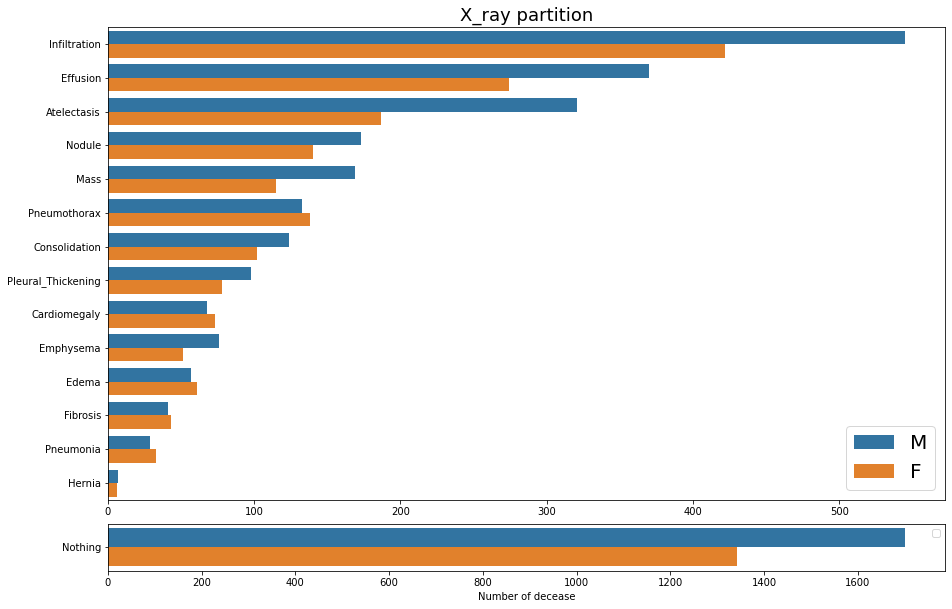

In [ ]:
plt.figure(figsize=(15,10))
gs = gridspec.GridSpec(8,1)
ax1 = plt.subplot(gs[:7, :])
ax2 = plt.subplot(gs[7, :])
data1 = pd.melt(chest_temp,
             id_vars=['Patient Gender'],
             value_vars = list(pathology_list),
             var_name = 'Category',
             value_name = 'Count')
data1 = data1.loc[data1.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data1, ax=ax1, order = data1['Category'].value_counts().index)
ax1.set( ylabel="",xlabel="")
ax1.legend(fontsize=20)
ax1.set_title('X_ray partition',fontsize=18);

chest_df['Nothing']=chest_df['Finding Labels'].apply(lambda x: 1 if 'No Finding' in x else 0)

data2 = pd.melt(chest_df,
             id_vars=['Patient Gender'],
             value_vars = list(['Nothing']),
             var_name = 'Category',
             value_name = 'Count')
data2 = data2.loc[data2.Count>0]
g=sns.countplot(y='Category',hue='Patient Gender',data=data2,ax=ax2)
ax2.set( ylabel="",xlabel="Number of decease")
ax2.legend('')
plt.subplots_adjust(hspace=.5)

In [ ]:
df=chest_temp.groupby('Finding Labels').count().sort_values('Patient ID',ascending=False)
df1=df[['|' in index for index in df.index]].copy()
df2=df[['|' not in index for index in df.index]]
df2=df2[['No Finding' not in index for index in df2.index]]
df2['Finding Labels']=df2.index.values
df1['Finding Labels']=df1.index.values

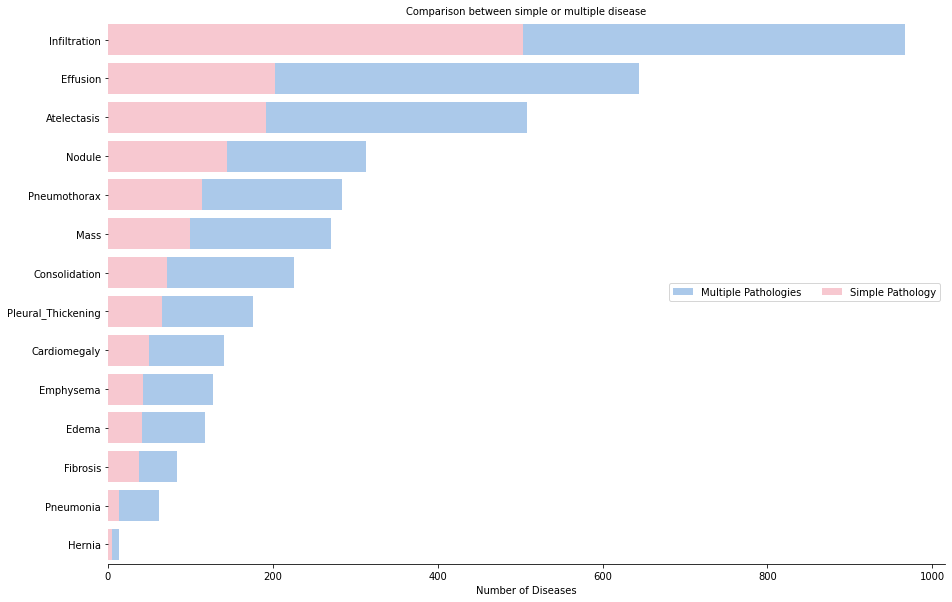

In [ ]:
f, ax = plt.subplots(sharex=True,figsize=(15, 10))
sns.set_color_codes("pastel")
g=sns.countplot(y='Category',data=data1, ax=ax, order = data1['Category'].value_counts().index,color='b',label="Multiple Pathologies")
sns.set_color_codes("muted")
g=sns.barplot(x='Patient ID',y='Finding Labels',data=df2, ax=ax, color="pink",label="Simple Pathology")
ax.legend(ncol=2, loc="center right", frameon=True,fontsize=10)
ax.set( ylabel="",xlabel="Number of Diseases")
ax.set_title("Comparison between simple or multiple disease",fontsize=10)      
sns.despine(left=True)

### Preprocessing Dataset

In [107]:
preprocessed_labels=[]

for i in range(len(labels_initial)):
    split_labels=labels_initial[i].split("|")
    if len(split_labels)==1:
            preprocessed_labels.append(split_labels)
    else:
        label=[]
        for j in range(len(split_labels)):
            label.append(split_labels[j])
        preprocessed_labels.append(label)

In [109]:
preprocessed_labels[:100]

[['Emphysema', 'Infiltration', 'Pleural_Thickening', 'Pneumothorax'],
 ['Cardiomegaly', 'Emphysema'],
 ['No Finding'],
 ['Atelectasis'],
 ['Cardiomegaly', 'Edema', 'Effusion'],
 ['Consolidation', 'Mass'],
 ['No Finding'],
 ['No Finding'],
 ['Effusion'],
 ['No Finding'],
 ['Consolidation', 'Effusion', 'Infiltration', 'Nodule'],
 ['Mass'],
 ['No Finding'],
 ['No Finding'],
 ['Effusion'],
 ['Effusion'],
 ['Effusion'],
 ['No Finding'],
 ['Mass', 'Pneumothorax'],
 ['Cardiomegaly', 'Consolidation'],
 ['Consolidation'],
 ['Cardiomegaly', 'Consolidation'],
 ['Cardiomegaly', 'Consolidation'],
 ['Pneumothorax'],
 ['No Finding'],
 ['Effusion'],
 ['Consolidation', 'Pleural_Thickening'],
 ['Infiltration', 'Nodule'],
 ['No Finding'],
 ['Atelectasis'],
 ['Atelectasis'],
 ['Fibrosis'],
 ['Infiltration'],
 ['Infiltration'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['No Finding'],
 ['Fibrosis'],
 ['No Finding'],
 ['Consolidation'],
 ['Emphysema'],
 ['No Finding'],
 ['No Finding'],
 ['Infiltra

In [ ]:
resize=256
path_image="/content/drive/My Drive/images/"
disease_labels=[]
image_loaded=[]

In [ ]:
for i in tqdm(range(len(chest_df["Image Index"]))):
    image=cv2.imread(path_image+chest_df["Image Index"][i]) 
    if len(image.shape)>2: 
      
        image_reshape=cv2.resize(image,(resize,resize)) 
        image_loaded.append(image_reshape[:,:,:4]) 
    else :
        image=np.dstack([image] * 3)
        image_reshape=cv2.resize(image,(resize,resize)) 
        image_loaded.append(image_reshape)

100%|██████████| 5606/5606 [49:53<00:00,  1.87it/s]


In [ ]:
image_loaded[0].shape

(256, 256, 3)

In [ ]:
file_name = "/content/drive/My Drive/chest_xray_image_list_reshape.pkl"

In [ ]:
open_file = open(file_name, "wb")
pickle.dump(image_loaded, open_file)
open_file.close()

In [ ]:
open_file = open(file_name, "rb")
loaded_list = pickle.load(open_file)
open_file.close()
print(loaded_list[0])

[[[ 85  85  85]
  [ 84  84  84]
  [ 83  83  83]
  ...
  [  5   5   5]
  [  5   5   5]
  [  5   5   5]]

 [[ 88  88  88]
  [ 88  88  88]
  [ 87  87  87]
  ...
  [  5   5   5]
  [  5   5   5]
  [  5   5   5]]

 [[167 167 167]
  [167 167 167]
  [166 166 166]
  ...
  [  5   5   5]
  [  5   5   5]
  [  5   5   5]]

 ...

 [[127 127 127]
  [130 130 130]
  [151 151 151]
  ...
  [ 21  21  21]
  [ 45  45  45]
  [  4   4   4]]

 [[122 122 122]
  [136 136 136]
  [149 149 149]
  ...
  [ 37  37  37]
  [ 18  18  18]
  [  2   2   2]]

 [[ 94  94  94]
  [106 106 106]
  [110 110 110]
  ...
  [ 35  35  35]
  [  8   8   8]
  [  4   4   4]]]


In [ ]:
len(preprocessed_labels), len(loaded_list) 
#len(image_loaded),

(5606, 5606)

In [ ]:
#function to display reshaped images
def display_resize_image(image, labels , total_image ):
    #to generate a random numbers
    n=np.random.randint(0,len(image),total_image)
    plt.figure(figsize=(40,20))
    j = total_image/10
    for _,i in enumerate(n):
        plt.subplot(j,10,_+1)
        plt.imshow(image[i] , cmap="gray")
        label=""
        for x in labels[i]:
            label+=x+" , "            
        plt.title(label)
        plt.xticks([]),plt.yticks([])
    plt.show()

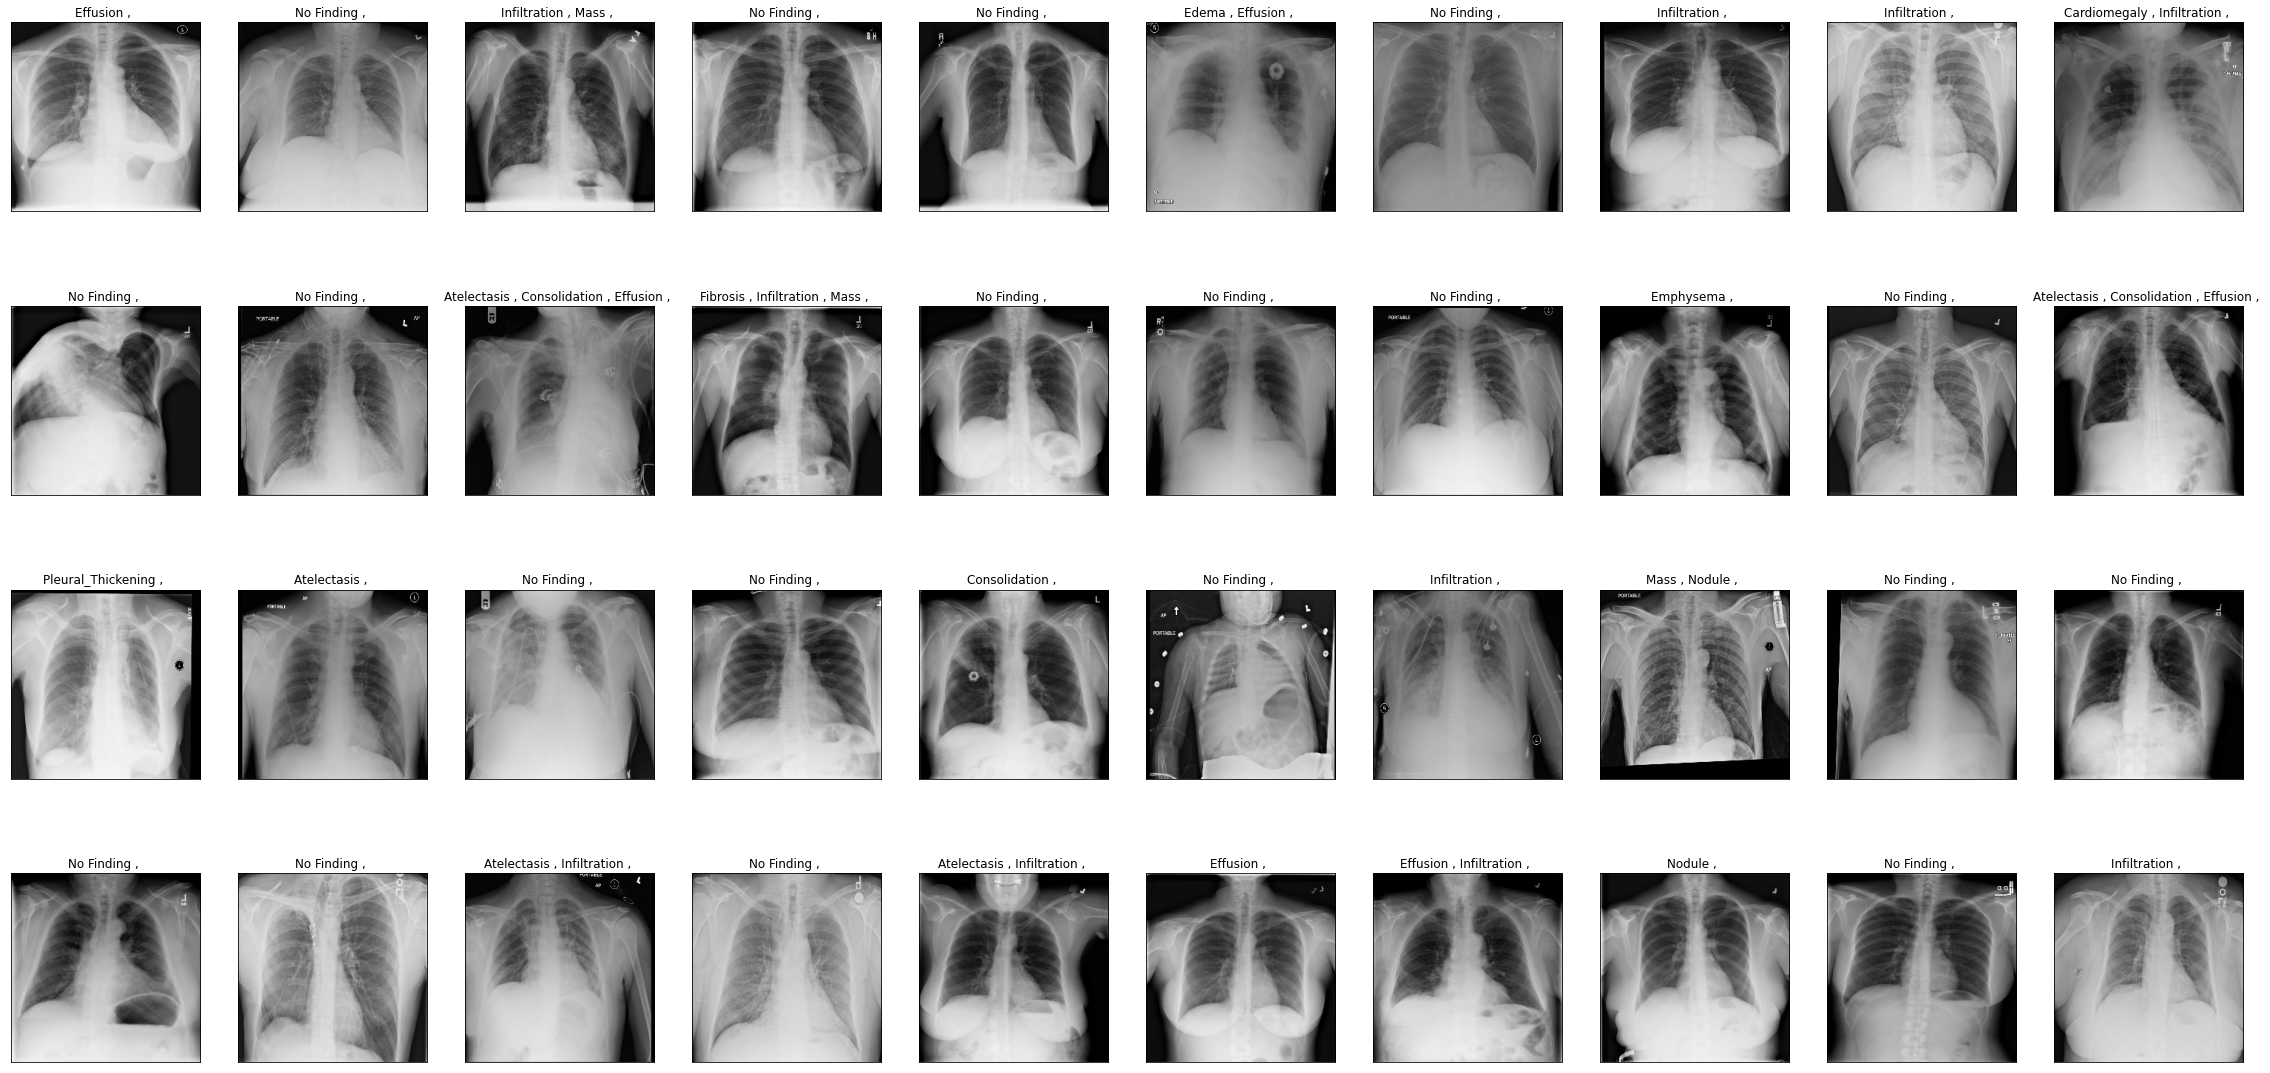

In [ ]:
display_resize_image(image_loaded,preprocessed_labels,40)

In [111]:
diseases={0:"Hernia",1:"Pneumonia",2:"Fibrosis",3:"Edema",4:"Emphysema",5:"Cardiomegaly",6:"Pleural_Thickening",
          7:"Consolidation",8:"Pneumothorax",9:"Mass",10:"Nodule",11:"Atelectasis",12:"Effusion",13:"Infiltration",
          14:"No Finding"}

In [112]:
def disease_name(key):
    return diseases[key]

def disease_key(name):
    for key,value  in diseases.items():
        if value ==name:
            return key

In [113]:
#label encoder
for i in tqdm(range(len(preprocessed_labels))):
    preprocessed_labels[i]=[disease_key(x) for x in preprocessed_labels[i]]

100%|██████████| 5606/5606 [00:00<00:00, 350384.73it/s]


In [114]:
preprocessed_labels[:100]

[[4, 13, 6, 8],
 [5, 4],
 [14],
 [11],
 [5, 3, 12],
 [7, 9],
 [14],
 [14],
 [12],
 [14],
 [7, 12, 13, 10],
 [9],
 [14],
 [14],
 [12],
 [12],
 [12],
 [14],
 [9, 8],
 [5, 7],
 [7],
 [5, 7],
 [5, 7],
 [8],
 [14],
 [12],
 [7, 6],
 [13, 10],
 [14],
 [11],
 [11],
 [2],
 [13],
 [13],
 [14],
 [14],
 [14],
 [14],
 [2],
 [14],
 [7],
 [4],
 [14],
 [14],
 [13],
 [7, 9],
 [14],
 [11, 13, 9, 6],
 [13],
 [14],
 [14],
 [13],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [14],
 [13, 10],
 [14],
 [4],
 [14],
 [13],
 [14],
 [14],
 [8],
 [4, 9],
 [14],
 [14],
 [14],
 [14],
 [14],
 [5, 4],
 [14],
 [14],
 [14],
 [14],
 [14],
 [13],
 [8],
 [4, 8],
 [4, 13],
 [14],
 [14],
 [14],
 [14],
 [13],
 [7, 12, 13],
 [7, 2],
 [14],
 [2, 6],
 [14],
 [14],
 [14],
 [12, 13],
 [2],
 [14],
 [14],
 [14]]

In [ ]:
y_binary=MultiLabelBinarizer()
bin_labels=y_binary.fit_transform(preprocessed_labels)
bin_labels[0],bin_labels

(array([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0]),
 array([[0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 1],
        ...,
        [0, 0, 0, ..., 0, 1, 0],
        [0, 0, 0, ..., 0, 0, 1],
        [0, 0, 0, ..., 0, 0, 1]]))

In [ ]:
img_loaded=np.array(loaded_list)
b_labels=np.array(bin_labels)

In [ ]:
img_loaded.shape, b_labels.shape

((5606, 256, 256, 3), (5606, 15))

In [ ]:
X_train, y_train, X_test, y_test = iterative_train_test_split(img_loaded, b_labels, test_size = 0.2 )
X_val, y_val, X_test, y_test = iterative_train_test_split(X_test, y_test, test_size = 0.6)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape,X_val.shape,y_val.shape

((4495, 256, 256, 3),
 (4495, 15),
 (665, 256, 256, 3),
 (665, 15),
 (446, 256, 256, 3),
 (446, 15))

### Data Augmentation

In [ ]:
gen=ImageDataGenerator(
        rescale=1/255.0,
        samplewise_std_normalization=True,
        samplewise_center=True,
        rotation_range=90)

In [ ]:
batch_size=64 

In [ ]:
train_gen=gen.flow(X_train,y_train ,batch_size=batch_size)
val_gen=gen.flow(X_val,y_val,batch_size=batch_size)
test_ge=gen.flow(X_test,y_test,batch_size=batch_size)

In [ ]:
from sklearn.utils import class_weight
x_gen,y_gen = train_gen.next()
y_gen = np.argmax(y_gen, axis=1)

"""class_weights = class_weight.compute_class_weight(
               'balanced',
                np.unique(y_gen), 
                y_gen)"""
class_weights = class_weight.compute_class_weight('balanced', np.unique(y_gen), 
                y_gen) 

In [ ]:
class_weights

array([1.33333333, 5.33333333, 1.77777778, 1.33333333, 5.33333333,
       5.33333333, 2.66666667, 0.66666667, 1.77777778, 1.33333333,
       2.66666667, 0.17204301])

In [ ]:
from keras.utils.data_utils import Sequence
from imblearn.over_sampling import RandomOverSampler
from imblearn.keras import balanced_batch_generator

class BalancedDataGenerator(Sequence):
    """ImageDataGenerator + RandomOversampling"""
    def __init__(self, x, y, datagen, batch_size=32):
        self.datagen = datagen
        self.batch_size = min(batch_size, x.shape[0])
        datagen.fit(x)
        self.gen, self.steps_per_epoch = balanced_batch_generator(x.reshape(x.shape[0], -1), y, sampler=RandomOverSampler(), batch_size=self.batch_size, keep_sparse=True)
        self._shape = (self.steps_per_epoch * batch_size, *x.shape[1:])
        
    def __len__(self):
        return self.steps_per_epoch

    def __getitem__(self, idx):
        x_batch, y_batch = self.gen.__next__()
        x_batch = x_batch.reshape(-1, *self._shape[1:])
        return self.datagen.flow(x_batch, y_batch, batch_size=self.batch_size).next()

In [ ]:
balanced_gen = BalancedDataGenerator(X_train, y_train, gen, batch_size=32)
steps_per_epoch = balanced_gen.steps_per_epoch

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


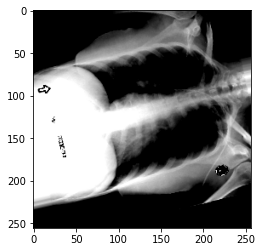

In [ ]:
train_image=train_gen.__getitem__(0)[0]
train_label=train_gen.__getitem__(0)[1]
plt.imshow(train_image[0])

### Densenet 169 Pre trained

In [ ]:
dn_model=DenseNet169(weights="imagenet", include_top=False)
#print(dn_model.layers)
for layer in dn_model.layers[:150]:
    #print(layer)
    layer.trainable=False

input_image=Input((resize,resize,3))
l1=Conv2D(512 , (3,3) , activation="relu")(dn_model(input_image))
l1=Conv2D(512 , (3,3) , activation="relu")(l1)
l1=Conv2D(512 , (3,3) , activation="relu" , name="for_class_activation")(l1)
Flattened_data=Flatten()(l1)

d1=Dense(2048, activation="relu")(Flattened_data)
d1=BatchNormalization()(d1)
d1=Dropout(0.2)(d1)

d1=Dense(1024, activation="relu")(d1)

d1=Dense(1024, activation="relu")(d1)
d1=BatchNormalization()(d1)
d1=Dropout(0.2)(d1)
d1=Dense(1024, activation="relu")(d1)

d1=Dense(512, activation="relu")(d1)
d1=BatchNormalization()(d1)
d1=Dropout(0.2)(d1)

d1=Dense(512, activation="relu")(d1)

d1=Dense(256, activation="relu")(d1)
d1=BatchNormalization()(d1)
d1=Dropout(0.2)(d1)

d1=Dense(256, activation="relu")(d1)
d1=Dense(128, activation="relu")(d1)
d1=Dense(128, activation="relu")(d1)
d1=Dense(64, activation="relu")(d1)

output=Dense(len(diseases), activation="sigmoid")(d1)

model=Model(inputs=input_image, outputs=output)
model.summary()
#plot_model(model, show_shapes=True, show_layer_names=True , to_file="densenet_model.png")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
densenet169 (Functional)     (None, None, None, 1664)  12642880  
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 512)         7668224   
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 512)         2359808   
_________________________________________________________________
for_class_activation (Conv2D (None, 2, 2, 512)         2359808   
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 2048)              4196

### Train Multi-Label Classifier on Augmented Images  

In [ ]:
with tf.device('/gpu:0'):
  """dn=[tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5 , verbose=1),
    tf.keras.callbacks.ModelCheckpoint("chestxray_model1.h5" , save_best_only=True ,verbose=1)]

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum =0.2)  , 
              loss=tf.keras.losses.binary_crossentropy , 
              metrics=["accuracy"])"""
  dn=[tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5 , verbose=1),
    tf.keras.callbacks.ModelCheckpoint("chestxray_model1.h5" , save_best_only=True ,verbose=1)]

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum =0.2)  , 
              loss=tf.keras.losses.binary_crossentropy , 
              metrics=['accuracy','binary_accuracy'])

  #dn_history=model.fit(X_train,y_train,epochs=15 ,steps_per_epoch=X_train.shape[0]/batch_size,validation_data=(X_val,y_val),callbacks=dn
   #                 , verbose=1 )
  dn_history=model.fit(train_gen,epochs=15 ,steps_per_epoch=X_train.shape[0]/batch_size,validation_data=(val_gen),callbacks=dn
                    , verbose=1 )
  """dn_history=model.fit_generator(train_gen,
                    steps_per_epoch=X_train.shape[0]/batch_size,
                    epochs=15, class_weight=class_weights,  validation_data=(X_val,y_val),callbacks=dn)"""

Epoch 1/15
70/70 [==============================] - 144s 1s/step - loss: 0.6659 - accuracy: 0.0537 - binary_accuracy: 0.5918 - val_loss: 0.6274 - val_accuracy: 0.5381 - val_binary_accuracy: 0.9154

Epoch 00001: val_loss improved from inf to 0.62742, saving model to chestxray_model1.h5
Epoch 2/15
70/70 [==============================] - 82s 1s/step - loss: 0.4240 - accuracy: 0.3767 - binary_accuracy: 0.8890 - val_loss: 0.4556 - val_accuracy: 0.5471 - val_binary_accuracy: 0.9226

Epoch 00002: val_loss improved from 0.62742 to 0.45558, saving model to chestxray_model1.h5
Epoch 3/15
70/70 [==============================] - 86s 1s/step - loss: 0.2663 - accuracy: 0.5347 - binary_accuracy: 0.9211 - val_loss: 0.3128 - val_accuracy: 0.5471 - val_binary_accuracy: 0.9224

Epoch 00003: val_loss improved from 0.45558 to 0.31284, saving model to chestxray_model1.h5
Epoch 4/15
70/70 [==============================] - 84s 1s/step - loss: 0.2292 - accuracy: 0.5364 - binary_accuracy: 0.9225 - val_loss: 

In [ ]:
model.save("Densenet169_nih.h5")

In [ ]:
model.evaluate(train_gen),model.evaluate(val_gen), model.evaluate(test_ge)
#model.evaluate(X_train,y_train),model.evaluate(X_val,y_val), model.evaluate(X_test,y_test)

11/11 [==============================] - 12s 1s/step - loss: 0.2136 - accuracy: 0.5504 - binary_accuracy: 0.9304


([0.2134852111339569, 0.5414905548095703, 0.9279941320419312],
 [0.21387003362178802, 0.5470852255821228, 0.9269058704376221],
 [0.21363238990306854, 0.5503759384155273, 0.9304260611534119])

- the Accuracy and Loss for DenseNet Model With 15 Epochs


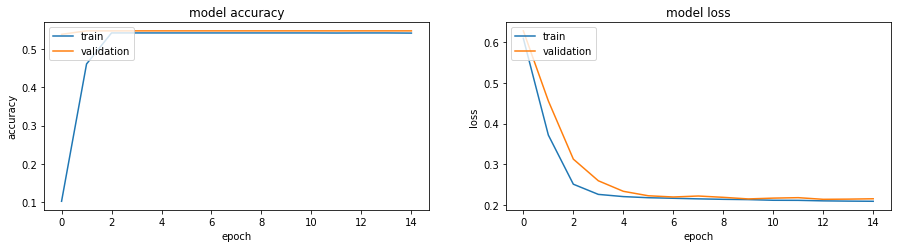

In [ ]:
print("- the Accuracy and Loss for DenseNet Model With 15 Epochs")
plt.figure(figsize=(40,20))

plt.subplot(5,5,1)
plt.plot(dn_history.history['accuracy'])
plt.plot(dn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')



# summarize history for loss
plt.subplot(5,5,2)
plt.plot(dn_history.history['loss'])
plt.plot(dn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

### Train Multi-Label Classifier on Original 80% Train Data   

In [ ]:
with tf.device('/gpu:0'):

  dn=[tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5 , verbose=1),
    tf.keras.callbacks.ModelCheckpoint("chestxray_model1.h5" , save_best_only=True ,verbose=1)]

  model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01,momentum =0.2)  , 
              loss=tf.keras.losses.binary_crossentropy , 
              metrics=['accuracy','binary_accuracy'])

  dn_history=model.fit(X_train,y_train,epochs=15 ,steps_per_epoch=X_train.shape[0]/batch_size,validation_data=(X_val,y_val),callbacks=dn
                    , verbose=1 )

Epoch 1/15
70/70 [==============================] - 111s 840ms/step - loss: 0.6551 - accuracy: 0.0906 - binary_accuracy: 0.6200 - val_loss: 0.6273 - val_accuracy: 0.0858 - val_binary_accuracy: 0.8793

Epoch 00001: val_loss improved from inf to 0.62734, saving model to chestxray_model1.h5
Epoch 2/15
70/70 [==============================] - 46s 660ms/step - loss: 0.4110 - accuracy: 0.2571 - binary_accuracy: 0.8978 - val_loss: 0.4489 - val_accuracy: 0.5508 - val_binary_accuracy: 0.9195

Epoch 00002: val_loss improved from 0.62734 to 0.44889, saving model to chestxray_model1.h5
Epoch 3/15
70/70 [==============================] - 47s 665ms/step - loss: 0.2571 - accuracy: 0.5482 - binary_accuracy: 0.9220 - val_loss: 0.3434 - val_accuracy: 0.5508 - val_binary_accuracy: 0.9171

Epoch 00003: val_loss improved from 0.44889 to 0.34342, saving model to chestxray_model1.h5
Epoch 4/15
70/70 [==============================] - 46s 662ms/step - loss: 0.2285 - accuracy: 0.5413 - binary_accuracy: 0.9220 

The Accuracy and Loss for DenseNet169 Model 15 Epochs


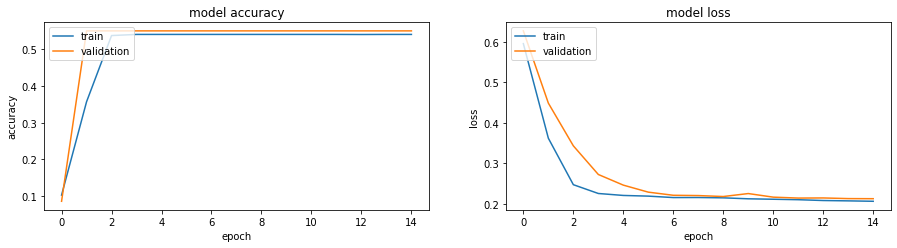

In [ ]:
print("The Accuracy and Loss for DenseNet169 Model 15 Epochs")
plt.figure(figsize=(40,20))

plt.subplot(5,5,1)
plt.plot(dn_history.history['accuracy'])
plt.plot(dn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')

plt.subplot(5,5,2)
plt.plot(dn_history.history['loss'])
plt.plot(dn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

### Train Multi-Label Classifier on Balanced Data using ImbalancedLearn Python Package  

In [ ]:
with tf.device('/gpu:0'):
  dn=[tf.keras.callbacks.EarlyStopping(monitor="val_loss" , patience=5 , verbose=1),
    tf.keras.callbacks.ModelCheckpoint("chestxray_model1.h5" , save_best_only=True ,verbose=1)]

  model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001)  , 
              loss=tf.keras.losses.binary_crossentropy , 
              metrics=['accuracy','binary_accuracy'])

  dn_history=model.fit_generator(balanced_gen,epochs=15 ,steps_per_epoch=X_train.shape[0]/batch_size,validation_data=(X_val,y_val),
                     callbacks=dn, verbose=1 )

Epoch 1/15
70/70 [==============================] - 96s 651ms/step - loss: 0.4776 - accuracy: 0.0654 - binary_accuracy: 0.7772 - val_loss: 23.6094 - val_accuracy: 0.0023 - val_binary_accuracy: 0.9158

Epoch 00001: val_loss improved from inf to 23.60939, saving model to chestxray_model1.h5
Epoch 2/15
70/70 [==============================] - 40s 571ms/step - loss: 0.3453 - accuracy: 0.0703 - binary_accuracy: 0.8861 - val_loss: 2.8087 - val_accuracy: 0.0878 - val_binary_accuracy: 0.9158

Epoch 00002: val_loss improved from 23.60939 to 2.80866, saving model to chestxray_model1.h5
Epoch 3/15
70/70 [==============================] - 40s 571ms/step - loss: 0.3299 - accuracy: 0.0721 - binary_accuracy: 0.8904 - val_loss: 2.8842 - val_accuracy: 0.0878 - val_binary_accuracy: 0.9158

Epoch 00003: val_loss did not improve from 2.80866
Epoch 4/15
70/70 [==============================] - 41s 580ms/step - loss: 0.3391 - accuracy: 0.0740 - binary_accuracy: 0.8883 - val_loss: 1.0180 - val_accuracy: 0.01

Accuracy and Loss for DenseNet169 Model 15 Epochs


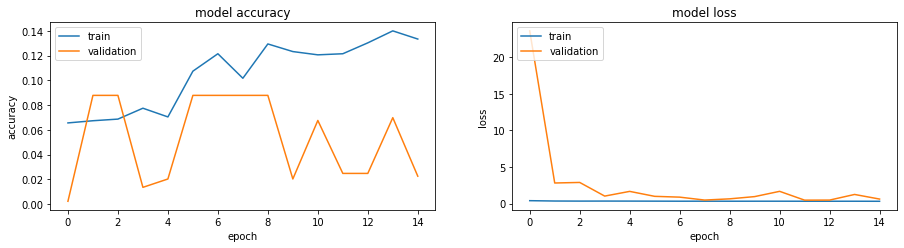

In [ ]:
print("Accuracy and Loss for DenseNet169 Model 15 Epochs")
plt.figure(figsize=(40,20))

plt.subplot(5,5,1)
plt.plot(dn_history.history['accuracy'])
plt.plot(dn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
# summarize history for loss
plt.subplot(5,5,2)
plt.plot(dn_history.history['loss'])
plt.plot(dn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()